In [1]:
from utils import *
from tonotopy import *
import findpeaks
from skimage import measure
import os

t_pre = 0.5#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)

In [2]:
path = "/auto/data6/eTheremin/MMELOIK/MMELOIK_20241119_SESSION_01/"


In [3]:
t_pre = 0.5#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)

In [40]:
data = np.load(path+'headstage_0/data_0.005.npy', allow_pickle=True)
features = np.load(path+'headstage_0/features_0.005.npy', allow_pickle=True)
gc = np.load(path+'headstage_0/good_clusters.npy', allow_pickle=True)
#gc = np.arange(32)


In [42]:
len(gc)

18

In [36]:
tones = get_played_frequency(features, t_pre, t_post, bin_width, 'tracking')
# prendre les valeurs uniques de tones
unique_tones = np.load(path+'headstage_0/unique_tones.npy', allow_pickle=True)
unique_tones = sorted(np.unique(tones))

In [43]:
unique_tones

[190.0,
 220.0,
 255.0,
 296.0,
 343.0,
 397.0,
 460.0,
 533.0,
 617.0,
 715.0,
 828.0,
 959.0,
 1111.0,
 1287.0,
 1490.0,
 1727.0,
 2000.0,
 2317.0,
 2684.0,
 3109.0,
 3601.0,
 4172.0,
 4832.0,
 5598.0,
 6484.0,
 7511.0,
 8701.0,
 10079.0,
 11676.0,
 13525.0,
 15667.0,
 18149.0,
 21024.0]

In [38]:
def plot_heatmap_bandwidth_both_conditions(heatmaps_tr, heatmaps_pb,threshold, gc,unique_tones, min_freq, max_freq, bin_width, psth_bins, t_pre,path, folder, condition):
    """""
    Best function pour déterminer la bandwidth et plotter la heatmap et les contours de la bandwidth
    input : heatmaps(contenant plusieurs clusters), le threshold pour la detection du pic, good_clusters
        unique_tones (les fréquences jouées), min_freq, max_freq : les indices des fréquences qu'on exclut (pas assez de présentations)
        condition : 'tracking' ou 'playback'
    output : save plot des heatmap avec la bandwidth entourée .png
            save tableau des heatmaps telles que plottée (avec les psth) .npy
            save tableau contenant les bandwidth de chaque cluster .npy
            
    """
    heatmaps = [heatmaps_tr, heatmaps_pb]

    vmax_tr = 2 * np.std(heatmaps_tr)
    vmax_pb = 2 * np.std(heatmaps_pb)

    vmax = np.max(vmax_pb, vmax_tr)
    vmin = -np.max(vmax_pb, vmax_tr)
    # pour les plots:
    for heatmap in heatmaps :
    #num_rows, num_columns = get_plot_geometry(gc)
    
        num_plots, num_rows, num_columns = get_better_plot_geometry(gc)


        # Create a figure with subplots
        fig, axes = plt.subplots(4, 8, figsize=(16, 8))
        fig.suptitle(f'Heatmaps clusters {condition}', y=1.02)
        plt.subplots_adjust() 
        
        # Flatten the axis array if it's more than 1D
        #if num_rows > 1 and num_columns > 1:
            #axes = axes.flatten()
        #
        bandwidth = []
        plotted_heatmap = []
        peaks = []
        for n, cluster in enumerate(gc):
            if cluster < num_plots:
                row, col = get_plot_coords(n)
                #print(cluster)
                heatmap_cluster = np.array(heatmaps[n])
                hm, peak = detect_peak(heatmaps, n)
                #heatmap_min = np.min(heatmap_cluster)
                #heatmap_max = np.max(abs(heatmap_cluster))
                #abs_max = max(abs(heatmap_min), abs(heatmap_max))
                #abs_max = np.max(abs(heatmap_cluster[min_freq:-max_freq]))
                abs_max = np.max(abs(heatmap_cluster[3:-3]))*0.4
                contours = get_contour(hm, threshold)
                #j'essaye en prenant la absolute value de hm
                #contours = get_contour(np.abs(hm), threshold)
                
            # Je retire la moyenne pre-stim ligne par ligne (fréquence par fréquence)
                t_0 = int(t_pre/bin_width)
                prestim_hm = heatmap_cluster[:, :t_0]
                mean_freq = np.mean(prestim_hm, axis=1)

                for i in range(heatmap_cluster.shape[0]):  # Parcours des lignes de A
                    heatmap_cluster[i] -= mean_freq[i]
                
                
                smoothed = smooth_2d(heatmap_cluster, 5)
                
                #je mets des zeros aux frequences trop hautes et trop basses où je n'ai pas
                #assez de présentations
                #lowf = np.zeros((min_freq+1, len(smoothed[0])))
                #highf = np.zeros((max_freq+1, len(smoothed[0])))
                
                #milieu = np.concatenate((lowf, smoothed[min_freq:-max_freq]))

                # Concaténation à l'arrière
                #milieu = np.concatenate((milieu, highf))

                vmin = -2 * np.std(smoothed)
                vmax = 2 * np.std(smoothed)

                norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
                img = axes[row, col].pcolormesh(smoothed, cmap='seismic', norm=norm)
                axes[row, col].set_xlabel('Time')
                #axes[row, col].set_yticks(np.arange(len(unique_tones)), unique_tones)
                axes[row, col].set_xlabel('Time')
                #axes[row, col].set_ylabel('Frequency [Hz]')
                axes[row, col].set_title(f'Cluster {cluster}')
                axes[row, col].axvline(x=t_0, color='black', linestyle='--') # to print a vertical line at the stim onset time
            
            

                #Je ne prends la réponse qu'entre 40 et 60ms
                #max = 0
                #min = len(unique_tones[min_freq:-max_freq])-2
                max_length =  0    
                x_c, y_c, minf, maxf = np.nan, np.nan, 0,0 # au cas où on trouve pas de contour
                for contour in contours:
                    if ((contour[:, 1] > t_0-5).all() and (contour[:, 1] < t_0+10).all()):
                        if len(contour[:, 0])>max_length:
                            max_length = len(contour[:, 0])
                            x_c = contour[:, 1]
                            y_c = contour[:, 0]
                            maxf = np.max(contour[:, 0])
                            minf = np.min(contour[:, 0])
                            test = contour[:, 0]
                            if maxf<len(unique_tones)-1:
                                maxf+=1
                #axes[row, col].plot(x_c, y_c, linewidth=2, color='green')
                #print(plotted_freq[int(min)], plotted_freq[int(max)])
                # je mets np.nan dans bandwidth si je ne trouve pas de contour
                if max_length==0 or maxf==0:
                    bandwidth.append([np.nan, np.nan])
                    peaks.append(np.nan)
                else : 
                
                #je prends +1 dans le maxf
                    bandwidth.append([unique_tones[int(minf)], unique_tones[int(maxf)]])
                    peaks.append(unique_tones[peak[0]])
                plotted_heatmap.append(smoothed)
                #cbar_ax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
                #fig.colorbar(img, cax=cbar_ax)
            # Hide any unused subplots
        for ax in axes[num_plots:]:
            ax.axis('off')
    plt.tight_layout()  
    plt.savefig(path+folder+f'/heatmap_{condition}.png') # save the figure of the heatmap
    np.save(path+folder+f'/heatmap_bandwidth.npy', bandwidth) # save the values of the bandwidth
    np.save(path+folder+f'/heatmap_plot_{condition}.npy',plotted_heatmap ) # save the values of the heatmap as it is plotted 
    np.save(path+folder+f'/best_frequency_{condition}.npy', peaks)
    return ('all izz well')

calculating heatmaps
[  190   220   255   296   343   397   460   533   617   715   828   959
  1111  1287  1490  1727  2000  2317  2684  3109  3601  4172  4832  5598
  6484  7511  8701 10079 11676 13525 15667 18149 21024]
190
[0.3        0.25       0.33333333 0.35       0.51666667 0.31666667
 0.28333333 0.38333333 0.56666667 0.36666667 0.36666667 0.38333333
 0.41666667 0.4        0.28333333 0.3        0.21666667 0.31666667
 0.43333333 0.45       0.36666667 0.38333333 0.4        0.3
 0.4        0.41666667 0.3        0.36666667 0.36666667 0.36666667
 0.36666667 0.4        0.38333333 0.33333333 0.36666667 0.31666667
 0.35       0.35       0.4        0.41666667 0.35       0.4
 0.23333333 0.28333333 0.36666667 0.31666667 0.35       0.23333333
 0.33333333 0.31666667 0.3        0.23333333 0.45       0.4
 0.3        0.3        0.28333333 0.3        0.4        0.36666667
 0.38333333 0.41666667 0.31666667 0.4        0.28333333 0.45
 0.46666667 0.3        0.4        0.36666667 0.21666667 0.43333

'all izz well'

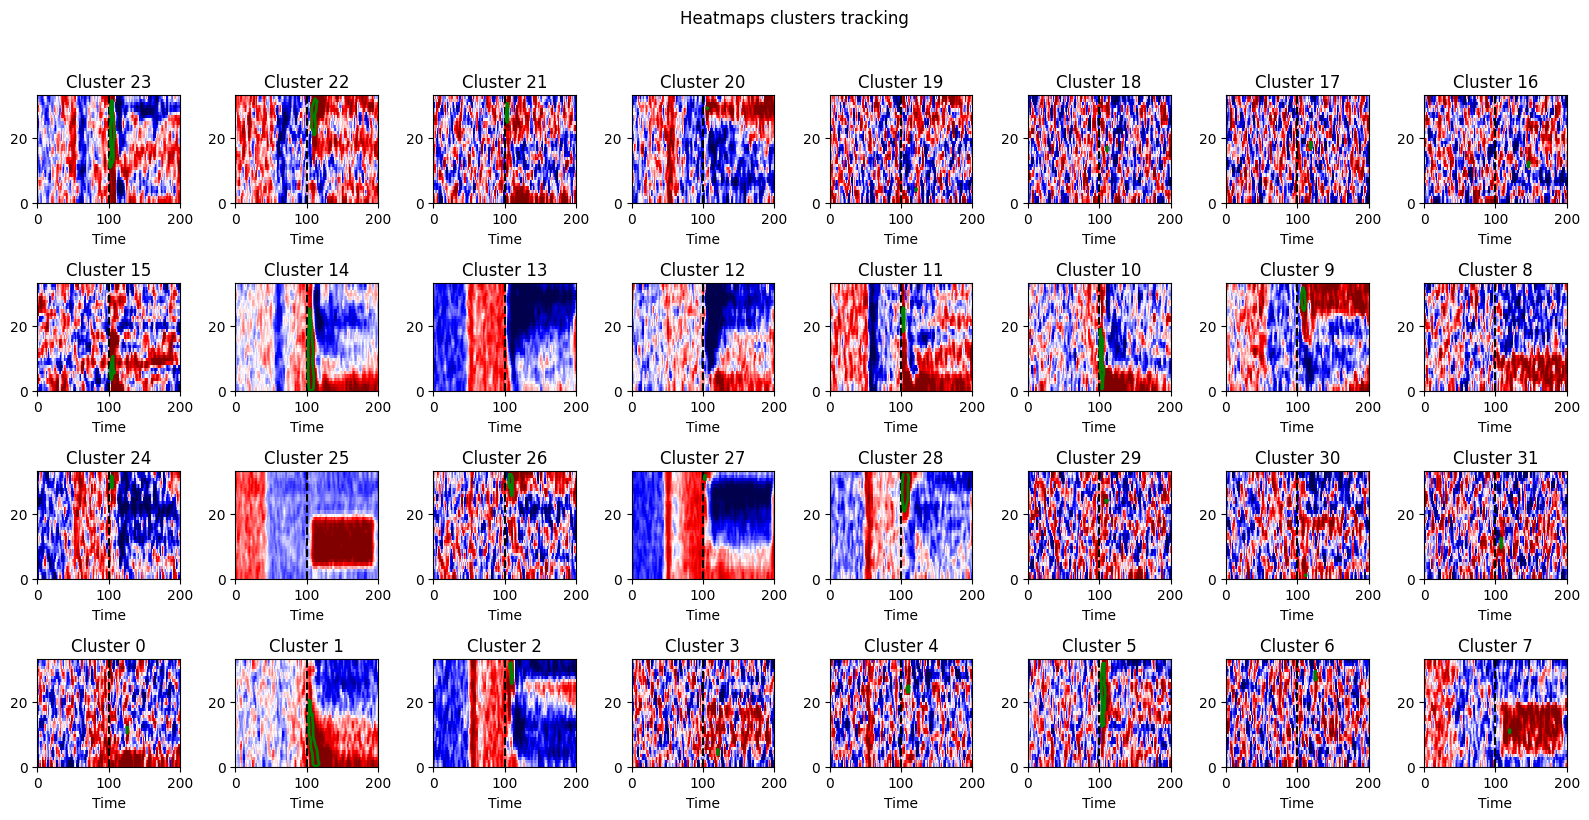

In [39]:
if not os.path.exists(path + 'heatmap_plot_playback.npy'):
    print("calculating heatmaps")
    heatmaps = get_tonotopy(data, features, t_pre, t_post, bin_width, gc, unique_tones, 0, 0, 'tracking', 'heatmaps')

else:
    heatmaps = np.load(path + 'heatmap_plot_playback.npy', allow_pickle = True)
    print('heatmaps already exist')

#récupérer les heatmaps
plot_heatmap_bandwidth(heatmaps,3, gc,unique_tones, 2, 2, bin_width, psth_bins, t_pre,path, '', 'tracking')

In [8]:
heatmaps = get_tonotopy(data, features, t_pre, t_post, bin_width, gc, unique_tones, 0, 0, 'tracking', 'heatmaps')


In [18]:
tones = get_played_frequency(features, t_pre, t_post, bin_width, 'tracking')

In [ ]:

def get_tonotopy(data, features, t_pre, t_post, bin_width, good_clusters, unique_tones, max_freq, min_freq, condition, save_name):
    """""
    
    Fonction qui pour une session renvoie
    les heatmaps (psth x freq) pour la tonotopie mais ne les plot pas
    une heatmap par neurone
    uniquement les good_clusters
    attention : les heatmaps sont brutes (pas de traitements, ni smoothed... etc)
    
    input : data, features, t_pre, t_post (pour le psth), bins, good_clusters et condition ("tracking" ou "playback)
            unique_tones : ce sont les tons uniques qui ont été joués pendant la session (33 en tout)
            max_freq, min_freq : indices min et max des fréquences extrêmes à partir desquelles on ne prend pas les psth pour les heatmap
            (car pas assez de présentations donc ca déconne) min_freq = 5, max_freq = 7
            condition : 'tracking' ou 'playback
    ouput : 1 tableau contenant 1 heatmap par good_cluster 
            heatmap non smoothée
    """
    
    #je prends les psth de chaque neurones et la fréquence associée à chaque psth
    psth = get_psth(data, features, t_pre, t_post, bin_width, good_clusters, condition)
    tones = get_played_frequency(features, t_pre, t_post, bin_width, condition)
    tones = [int(x) for x in tones]
    unique_tones = [int(x) for x in unique_tones]
    
    psth_bins = np.arange(-t_pre, t_post + bin_width, bin_width)
    
    n_clus = len(good_clusters)
     

    tones = np.array(tones)
    tones = [int(x) for x in tones]
    unique_tones_test = np.unique(tones)
    unique_tones = np.array([int(x) for x in unique_tones])

    heatmaps = []

    for c, clus in enumerate(good_clusters):  
        clus_psth = np.array(psth[c])
        average_psth_list = []
        
        for tone in unique_tones:

            mask = (tones == tone)
            if len(clus_psth[mask])>0: #au moins 20 présentations d'une fréquence
                average_psth = np.mean(clus_psth[mask], axis=0)
                average_psth_list.append(average_psth)
                print(average_psth)
            else:
                average_psth_list.append(np.zeros_like(psth_bins[:-1]))
    
        average_psths_array = np.array(average_psth_list)
        
        t_0 = int(t_pre/bin_width)
        # faire la moyenne sur toute la heatmap
        #mu = np.nanmean(average_psths_array[:][0:t_0], axis=0)
        #mu = np.nanmean(mu, axis=0)
        
        #je retire la moyenne de la heatmap avant le stim
        #trouver le bin du stim
        
        
        #heatmap = average_psths_array[min_freq:-max_freq]-mu
        #heatmap = average_psths_array-mu
        heatmap = average_psths_array 
        heatmaps.append(heatmap)
    
    return heatmaps

In [26]:
hmm =  get_tonotopy(data, features, t_pre, t_post, bin_width, gc, unique_tones, 0, 0, 'tracking', "")

In [28]:
psth = get_psth(data, features, t_pre, t_post, bin_width, gc, 'tracking')
tones = get_played_frequency(features, t_pre, t_post, bin_width, 'tracking')
tones = [int(x) for x in tones]
unique_tones = [int(x) for x in unique_tones]

In [29]:
tones

[5598,
 21024,
 1490,
 8701,
 715,
 4832,
 343,
 2684,
 533,
 18149,
 959,
 397,
 6484,
 190,
 15667,
 1287,
 1727,
 11676,
 255,
 828,
 7511,
 220,
 617,
 296,
 10079,
 1111,
 13525,
 3109,
 2000,
 2317,
 4172,
 460,
 3601,
 296,
 6484,
 3109,
 8701,
 21024,
 1287,
 2317,
 2000,
 715,
 15667,
 220,
 959,
 13525,
 617,
 7511,
 190,
 397,
 1490,
 10079,
 3601,
 18149,
 828,
 4832,
 533,
 5598,
 343,
 255,
 1111,
 460,
 2684,
 1727,
 11676,
 4172,
 4172,
 828,
 343,
 8701,
 5598,
 3601,
 533,
 1727,
 2000,
 617,
 15667,
 6484,
 220,
 255,
 959,
 18149,
 460,
 13525,
 10079,
 7511,
 296,
 11676,
 397,
 190,
 1287,
 21024,
 4832,
 3109,
 1490,
 1111,
 2684,
 2317,
 715,
 1490,
 21024,
 18149,
 255,
 3601,
 8701,
 6484,
 296,
 1287,
 10079,
 2000,
 4832,
 397,
 715,
 828,
 7511,
 2317,
 959,
 1111,
 5598,
 15667,
 13525,
 533,
 3109,
 617,
 2684,
 4172,
 220,
 11676,
 1727,
 343,
 460,
 190,
 715,
 1727,
 1490,
 828,
 5598,
 255,
 2317,
 15667,
 2684,
 397,
 343,
 7511,
 1111,
 13525,
 1007

In [30]:
unique_tones

[]

In [11]:
features

array([{'Played_frequency': 0.0, 'Condition': 0.0, 'Block': 0.0, 'Frequency_changes': False},
       {'Played_frequency': 0.0, 'Condition': 0.0, 'Block': 0.0, 'Frequency_changes': False},
       {'Played_frequency': 0.0, 'Condition': 0.0, 'Block': 0.0, 'Frequency_changes': False},
       ...,
       {'Played_frequency': 11676.0, 'Condition': 0.0, 'Block': 0.0, 'Frequency_changes': False},
       {'Played_frequency': 11676.0, 'Condition': 0.0, 'Block': 0.0, 'Frequency_changes': False},
       {'Played_frequency': 11676.0, 'Condition': 0.0, 'Block': 0.0, 'Frequency_changes': False}],
      dtype=object)

In [9]:
heatmaps

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]